# Import Library

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files, drive
import os
import numpy as np

# Load Dataset

In [2]:
dataset_url = "https://raw.githubusercontent.com/HAJAR-Enterprise/ML-Repo/refs/heads/main/Datasets/labeled_comments.csv"

df = pd.read_csv(dataset_url)
texts = df['cleaned_comment'].astype(str).tolist()
labels = df['label'].tolist()

print("Distribusi Label:")
print(df['label'].value_counts())

Distribusi Label:
label
0    8248
1    7629
Name: count, dtype: int64


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15877 entries, 0 to 15876
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   author              15877 non-null  object
 1   comment             15877 non-null  object
 2   normalized_comment  15876 non-null  object
 3   cleaned_comment     15873 non-null  object
 4   label               15877 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 620.3+ KB


In [4]:
df.sample(10)

,author,comment,normalized_comment,cleaned_comment,label
13851,@kierramichelledix-t2u,menurut gw sih situs adil yah di 🚩𝙎𝙂𝙄88🚩 soaln...,menurut saya sih situs adil yah di SGI88 soaln...,menurut saya sih situs adil yah di sgi88 soaln...,1
1339,@DaniWahyudi-b5k,"⭐𝘼𝙇𝙀𝙓𝙄𝙎17 emang paling top dah, ga pernah biki...","ALEXIS17 emang paling top dah, tidak pernah me...",alexis17 emang paling top dah tidak pernah mem...,1
5262,@kussvia6494,"logika hukum sederhananya, yg buat ijazah itu ...","logika hukum sederhananya, yang buat ijazah it...",logika hukum sederhananya yang buat ijazah itu...,0
4222,@HermanSyah-u2m,Kya Roy ini bikin gaduh Indonesian adu domba a...,Kya Roy ini membuat gaduh Indonesian adu domba...,kya roy ini membuat gaduh indonesian adu domba...,0
10056,@kicaukopi1274,"Lah, ini kan Lenis Kogoya, yang dulu.....😂😂😂","Lah, ini kan Lenis Kogoya, yang dulu.....",lah ini kan lenis kogoya yang dulu,0
12334,@CarmanAnareta-n7r,Banyak pilihan game *GUNUNGWIN* emang situs pi...,Banyak pilihan game *GUNUNGWIN* emang situs pi...,banyak pilihan game gunungwin emang situs pili...,1
3316,@AndiKartika-c3h,"Literally auto cuan, di ALEXIS17 pola gacor-ny...","Literally langsung cuan, di ALEXIS17 pola gaco...",literally langsung cuan di alexis17 pola gacor...,1
12033,@JayaSri-dm9eb,"Aku adalah pemenang, dan ❄️ *KYT4D* ❄️ adalah ...","Aku adalah pemenang, dan *KYT4D* adalah keberu...",aku adalah pemenang dan kyt4d adalah keberuntu...,1
4818,@ajiajiaji2370,Roy Suryo cs sungguh Manusia yg tidak punya adab,Roy Suryo dan kawan kawan sungguh Manusia yang...,roy suryo dan kawan kawan sungguh manusia yang...,0
1272,@JacquelineCarlson-b8n,"Udah coba banyak tempat, tapi  BERKAH99  pal...","sudah coba banyak tempat, tetapi BERKAH99 pali...",sudah coba banyak tempat tetapi berkah99 palin...,1


# Preprocessing

In [5]:
# cek missing values
print("Missing values sebelum dihapus:")
print(df.isnull().sum())

# hapus missing values
df.dropna(inplace=True)
print("\nMissing values setelah dihapus:")
print(df.isnull().sum())

# cek dduplikat
print("\nData duplikat sebelum dihapus:", df.duplicated().sum())

# hapus duplikat
df.drop_duplicates(inplace=True)
print("Data duplikat setelah dihapus:", df.duplicated().sum())

Missing values sebelum dihapus:
author                0
comment               0
normalized_comment    1
cleaned_comment       4
label                 0
dtype: int64

Missing values setelah dihapus:
author                0
comment               0
normalized_comment    0
cleaned_comment       0
label                 0
dtype: int64

Data duplikat sebelum dihapus: 336
Data duplikat setelah dihapus: 0


In [6]:
print("\nUkuran dataset setelah preprocessing:", df.shape)


Ukuran dataset setelah preprocessing: (15537, 5)


## Data Splitting

In [7]:
# Membagi dataset menjadi data latih (training) dan data validasi (validation)
# - texts: daftar komentar yang sudah dibersihkan
# - labels: label kelas dari komentar
# - test_size=0.2: 20% data digunakan untuk validasi, sisanya 80% untuk training
# - random_state=42: agar hasil split selalu sama setiap dijalankan (reproducible)
# - stratify=labels: memastikan proporsi label di training dan validation tetap seimbang
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

## Load tokenizer dan model IndoBERT

In [8]:
# Nama model IndoBERT yang akan digunakan dari Hugging Face
model_name = "indobenchmark/indobert-base-p1"

# Memuat tokenizer dari model IndoBERT
# Tokenizer ini bertugas mengubah teks menjadi format token yang bisa diproses oleh model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Memuat model IndoBERT untuk tugas klasifikasi teks (sequence classification)
# num_labels=2 berarti model ini akan memprediksi 2 kelas
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenisasi dan konversi ke tf.data.Dataset

In [9]:
def tokenize(texts, labels):
    # Tokenisasi teks menggunakan tokenizer IndoBERT
    # truncation=True: memotong teks yang melebihi max_length
    # padding=True: menambahkan padding agar semua input punya panjang yang sama
    # max_length=128: panjang maksimum setiap input token
    # return_tensors="tf": hasil tokenisasi dikembalikan dalam format tensor TensorFlow
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=128, return_tensors="tf"
    )

    # Menggabungkan input token dan label menjadi format tf.data.Dataset
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),                     # input model berupa dictionary: input_ids, attention_mask, dll.
        tf.convert_to_tensor(labels)        # label target sebagai tensor
    ))

# Membuat dataset training: diacak (shuffle) agar training tidak overfit urutan data, lalu dikelompokkan per batch
train_dataset = tokenize(train_texts, train_labels).shuffle(1000).batch(16)

# Membuat dataset validasi tanpa shuffle, hanya batching
val_dataset = tokenize(val_texts, val_labels).batch(16)

# Modeling

## Compile model

In [10]:
# Menggunakan Adam optimizer dengan learning rate 5e-5 (umum untuk fine-tuning BERT)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Menggunakan SparseCategoricalCrossentropy karena label dalam bentuk integer
# from_logits=True karena output model belum melalui softmax
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Metrik evaluasi: akurasi
metrics = ['accuracy']

# Menyusun (compile) model dengan optimizer, loss function, dan metrik
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


## Callbacks

In [11]:
callbacks = [
    # Hentikan training lebih awal jika val_loss tidak membaik selama 2 epoch berturut-turut
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),

    # Simpan model terbaik (berdasarkan val_loss terendah) ke file 'best_model.keras'
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]


# Train model

In [12]:
history = model.fit(
    train_dataset,                  # Dataset untuk proses training
    validation_data=val_dataset,    # Dataset untuk validasi di setiap akhir epoch
    epochs=4,                       # Jumlah maksimum epoch untuk training
    callbacks=callbacks             # Daftar callback untuk kontrol training
)


Epoch 1/4
794/794 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9812

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


794/794 [==============================] - 438s 475ms/step - loss: 0.0682 - accuracy: 0.9812 - val_loss: 0.0496 - val_accuracy: 0.9899
Epoch 2/4
794/794 [==============================] - 358s 451ms/step - loss: 0.0403 - accuracy: 0.9914 - val_loss: 0.0525 - val_accuracy: 0.9874
Epoch 3/4
794/794 [==============================] - 419s 527ms/step - loss: 0.0287 - accuracy: 0.9946 - val_loss: 0.0416 - val_accuracy: 0.9934
Epoch 4/4
794/794 [==============================] - 344s 433ms/step - loss: 0.0911 - accuracy: 0.9798 - val_loss: 0.1215 - val_accuracy: 0.9726


# Evaluasi

## Plot grafik akurasi dan loss

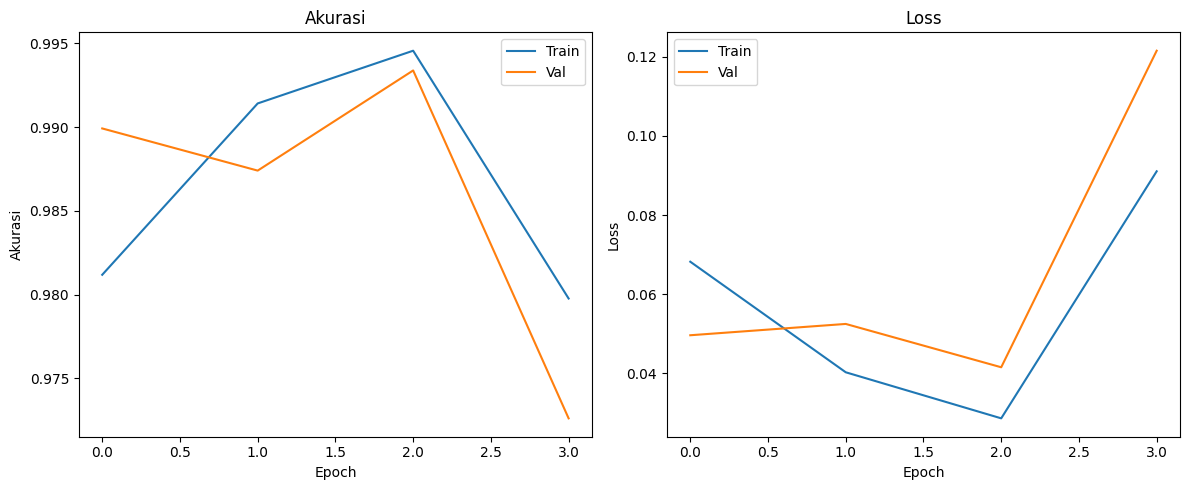

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Akurasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## Skor Akurasi

199/199 [==============================] - 32s 141ms/step

Classification Report:
              precision    recall  f1-score   support

  Bukan Judi       0.99      1.00      0.99      1650
        Judi       1.00      0.99      0.99      1526

    accuracy                           0.99      3176
   macro avg       0.99      0.99      0.99      3176
weighted avg       0.99      0.99      0.99      3176



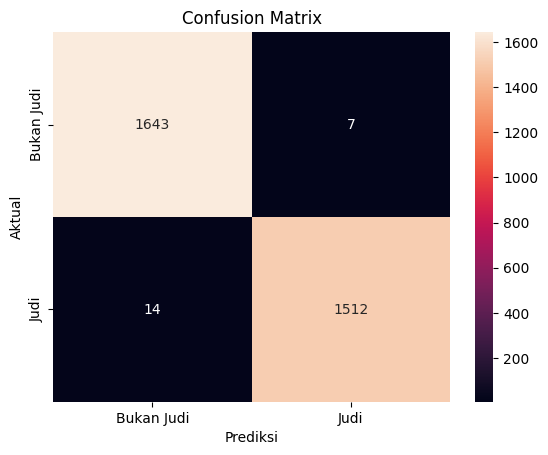

In [14]:
val_preds = np.argmax(model.predict(val_dataset).logits, axis=1)
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=["Bukan Judi", "Judi"]))

conf_matrix = confusion_matrix(val_labels, val_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=["Bukan Judi", "Judi"], yticklabels=["Bukan Judi", "Judi"])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

# Push model ke huggingface

In [15]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [16]:
model.save_pretrained("indobert-finetuned-judi")
tokenizer.save_pretrained("indobert-finetuned-judi")

('indobert-finetuned-judi/tokenizer_config.json',
 'indobert-finetuned-judi/special_tokens_map.json',
 'indobert-finetuned-judi/vocab.txt',
 'indobert-finetuned-judi/added_tokens.json',
 'indobert-finetuned-judi/tokenizer.json')

In [18]:
from huggingface_hub import HfApi, HfFolder, Repository, create_repo, upload_folder

repo_name = "indobert-finetuned-judi"
# Buat repo
create_repo(repo_name, private=False)

# Upload isi folder ke repo tersebut
upload_folder(
    folder_path="indobert-finetuned-judi",
    repo_id=f"fhru/{repo_name}",
    commit_message="Upload fine-tuned IndoBERT for comment classification"
)


Uploading...:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fhru/indobert-finetuned-judi/commit/d31712f02baee26e80a0d50f89bb9981e95ed3e0', commit_message='Upload fine-tuned IndoBERT for comment classification', commit_description='', oid='d31712f02baee26e80a0d50f89bb9981e95ed3e0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fhru/indobert-finetuned-judi', endpoint='https://huggingface.co', repo_type='model', repo_id='fhru/indobert-finetuned-judi'), pr_revision=None, pr_num=None)

## Test Load model

In [24]:
loaded_model = TFAutoModelForSequenceClassification.from_pretrained("fhru/indobert-finetuned-judi")
loaded_tokenizer = AutoTokenizer.from_pretrained("fhru/indobert-finetuned-judi")

Some layers from the model checkpoint at fhru/indobert-finetuned-judi were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at fhru/indobert-finetuned-judi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Inference

In [25]:
def predict(texts):
    inputs = loaded_tokenizer(
        texts, padding=True, truncation=True, max_length=128, return_tensors="tf"
    )
    outputs = loaded_model(inputs)
    logits = outputs.logits
    probs = tf.nn.softmax(logits, axis=1).numpy()
    preds = np.argmax(probs, axis=1)
    confidences = np.max(probs, axis=1)

    labels = ["Bukan Judi Online", "Judi Online"]
    results = [
        f"{labels[pred]} (Confidence: {confidence:.2f})"
        for pred, confidence in zip(preds, confidences)
    ]
    return results

In [26]:
sample_texts = [
    "roy suryo itu kan penjahat yang keluar dari penjara kok membuat ulah lagi",
    "ya alloh ya rob penjarakan orang munafik",
    "kerennn contentnya kakak cari situs yang benar itu weton88",
    "weton88 tempat paling uhuy"
]

predictions = predict(sample_texts)
for text, result in zip(sample_texts, predictions):
    print(f"Komentar: \"{text}\" -> Prediksi: {result}")

Komentar: "roy suryo itu kan penjahat yang keluar dari penjara kok membuat ulah lagi" -> Prediksi: Bukan Judi Online (Confidence: 1.00)
Komentar: "ya alloh ya rob penjarakan orang munafik" -> Prediksi: Bukan Judi Online (Confidence: 1.00)
Komentar: "kerennn contentnya kakak cari situs yang benar itu weton88" -> Prediksi: Judi Online (Confidence: 1.00)
Komentar: "weton88 tempat paling uhuy" -> Prediksi: Judi Online (Confidence: 1.00)
